In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from pathlib import Path
from six.moves.urllib.request import urlopen
import soundfile as sf
import numpy as np
import pandas as pd
import math
from scipy import signal, stats, interpolate

import matplotlib.pyplot as plt
from scipy.io import wavfile

Download delle tracce audio a 256kHz. Per il criterio di Nyquist il massimo suono registrabile, senza aliasing, ho una frequenza dimezzata rispetto al sample rate. Il dataset MBARI offre tracce con samplrate di 2kHz, 16kHz e 256kHz. Siccome i mammiferi marini possono emettere vocalizzi fino a 160kHz utilizzo i file originali.

NOTA: per il momento non vale quanto sopra, utilizzo i file a 2kHz per semplicità

In [2]:
# Download di un file
bucket = 'pacific-sound-2khz'
year = 2017
month = 11
fr = 2.5
filename = 'MARS_20180101_092406.wav'
sample_rate = 256000
#filename = "MARS-20171101T000000Z-2kHz.wav"
#sample_rate = 2000

key = f'{year:04d}/{month:02d}/{filename}'
url = f'https://{bucket}.s3.amazonaws.com/{key}'
audio_dir = Path('media', 'audio') 
docs_dir = Path('media', 'docs') 

s3 = boto3.resource('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))
 
if not Path(audio_dir, filename).exists():
    print('Downloading') 
    s3.Bucket(bucket).download_file(key, Path(audio_dir, filename))
    print('Done') 

In [3]:
if sample_rate == int(2e3):
    start_hour = 5
    start_frame = int(sample_rate * start_hour * 3600)
    duration_frames =  int(sample_rate* 3600)

    pacsound_file = sf.SoundFile(Path(audio_dir, filename))
    pacsound_file.seek(start_frame)
    x = pacsound_file.read(duration_frames, dtype='float32')
else:
    x = wavfile.read(Path(audio_dir, filename))[1]

# Marine Mammals Detection
Per la detection dei vocalizzi dei mammiferi marini uso l'algoritmo di Weighted Signal Entropy come descritto nel paper [Entropy-Based Automatic Detection of Marine Mammal Tonal Calls](https://ieeexplore.ieee.org/document/10683973).
![Detection pipeline](media/docs/WSE_pipeline.gif)

## (b) Bandpass filter
Il file dato in input viene passato attraverso un filtro passa banda con una finestra di frequenze di limite superiore 15kHz.<br>
Il lower bound viene calcolato in modo adattivo secondo il seguente algoritmo:<br>
* Calcolo della short-time power spectral density (STPSD): serve per misurare come la potenza media del segnale è distribuita su frequenze diverse. La potenza media è la quantità di energia trasferita o distribuira in un intervallo di tempo. Si utilizza una Kaiser window e 2.5 Hz risoluzione di frequenza
* Vengono preparati i dati per il calcolo dell'entropia: $$p_{jk} = \frac{|s_{jk}|^{2}}{\sum _{j=1}^{J} |s_{jk}|^{2}},\;\; 1\leq j \leq J $$
* Viene calcolata la signal entropy per ogni intervallo di frequenza
* Posto un threshold di entropia a 0.85 il primo intervallo di frequenza con entropia superiore al threshold rappresenta il lower bound cercato

In [4]:
def psd_1sec(x, w, sr: int):
    """
    Computes power spectral density (PSD) estimates in 1` second bins on the input signal x
    :param x:  sample array of raw float measurements (to be converted to volts)
    :param w:  window function to be used for the PSD estimate
    :param sr:  sampling rate of the raw samples
    :return: power spectral density, array of sample frequencies, power spectral density in dB
    """

    # convert scaled voltage to volts
    v = x * 3

    # initialize empty spectrogram
    num_seconds = round(len(x) / sr)
    sample_num = int(sr/fr)
    nfreq = int(sample_num / 2 + 1)
    sg = np.empty((nfreq, num_seconds), float)
    spec = np.empty((nfreq, num_seconds), float)

    # process spectrogram
    spa = 1  # seconds per average
    for x in range(0, num_seconds):
        cstart = x * spa * sr
        cend = cstart + spa * sr
        f, psd = signal.welch(v[cstart:cend], fs=sr, window=w, nperseg=sample_num)
        hp = 177.9 if sample_rate == 2000 else 0
        db_psd = 10 * np.log10(psd)+hp
        sg[:, x] = psd
        spec[:, x] = db_psd

    return sg, f, spec

In [5]:
# Creazione della finestra di Kaiser con 2.5Hz risoluzione di frequenza
sample_num = int(sample_rate/fr)
kaiser_win = signal.windows.kaiser(sample_num, beta=14)

# Calcolo della STPSD con finestre di 1 secondo mantenendo la risoluzione in frequenza a 2.5Hz
psd_np, f, spec = psd_1sec(x, kaiser_win, sample_rate)
psd_df = pd.DataFrame(psd_np)
psd_np.shape

(51201, 600)

Text(0.5, 1.0, 'Calibrated spectrum levels')

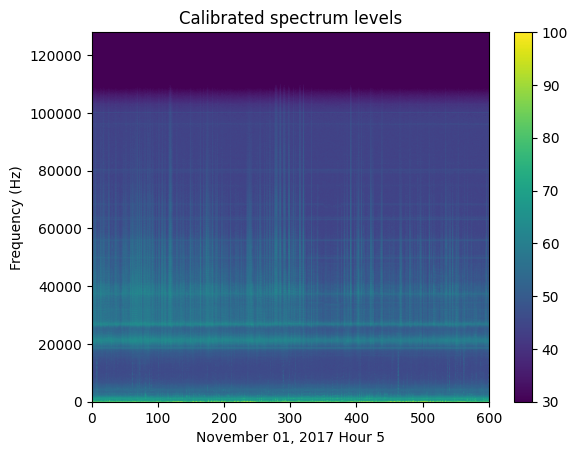

In [6]:
# Plot dello spettrogramma
plt.imshow(spec,extent=[0, 600, min(f), max(f)],aspect='auto',origin='lower',vmin=30,vmax=100)
plt.colorbar()
plt.xlabel('November 01, 2017 Hour 5')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')

In [7]:
# Calcolo dell'entropia del segnale
def se_calc(row):
    squared_row = np.abs(row) ** 2
    p = squared_row / np.sum(squared_row)
    if not math.isclose(np.sum(p), 1.0):
        print(f"La somma della riga non è 1, ma {np.sum(p)}")
    p = np.clip(p, 1e-12, 1)
    entropy = -(np.sum(p * np.log2(p)))/(np.log2(len(p)))
    return entropy

se_df = pd.DataFrame(f, columns=['frequency'])
se_df['entropy'] = psd_df.apply(se_calc, axis=1)

In [8]:
if not Path(docs_dir, 'denorm.csv').exists():
    psd_df.to_csv(Path(audio_dir, 'denorm.csv'), index=False)
if not Path(docs_dir, 'entropy.csv').exists():
    se_df.to_csv(Path(docs_dir, 'entropy.csv'), index=False)

Text(0, 0.5, 'SE')

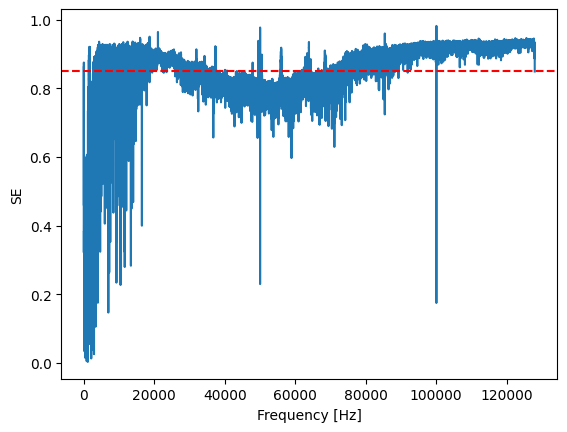

In [9]:
# Plot dell'entropia del segnale
plt.plot(se_df['frequency'], se_df['entropy'])
# Ipotetica linea di threshold suggerita nel paper
plt.axhline(y=0.85, color='r', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SE')

In [10]:
def get_lower_bound(se_df, threshold):
    low_entropy = se_df[se_df['entropy'] < threshold].index
    if low_entropy.empty:
        return None
    lowest_f = se_df.loc[low_entropy[0], 'frequency']
    f = lowest_f if lowest_f > 0 else se_df.loc[low_entropy[1], 'frequency']
    return f

In [11]:
# Ricerca del lower bound per il filtro passabanda
threshold = 0.85
lower_bound = get_lower_bound(se_df, threshold)
if lower_bound is not None:
    print(f"La frequenza più bassa con entropia < {threshold} è: {lower_bound}Hz")
else:
    print(f"Nessuna frequenza ha un'entropia < {threshold}")

La frequenza più bassa con entropia < 0.85 è: 2.5Hz


In [ ]:
# Creazione del filtro passa banda con upper bound fisso a 15kHz e lower bound calcolato
def create_bandpass_filter(lower_bound, upper_bound, sample_rate):
    # Scaling del lower ed upper bound per adattali alla frequenza di campionamento
    nyquist = 0.5 * sample_rate
    low = lower_bound / nyquist
    high = upper_bound / nyquist
    b, a = signal.butter(4, [low, high], fs=sample_rate, btype='band')
    return b, a

upper_bound = 15000
b, a = create_bandpass_filter(lower_bound, upper_bound, sample_rate)
filtered_x = signal.lfilter(b, a, x)
filtered_x.shape, x.shape


Frequenza bassa: 1.953125e-05, Frequenza alta: 0.1171875


((153600000,), (153600000,))

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(filtered_x)
plt.title('Filtered Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

: 